# Library imports, configurations

In [3]:
import os
import cv2
import subprocess
import seaborn as sns
import s3fs
import pandas as pd
import numpy as np
from PIL import Image
import pyvips
from joblib import dump
from pathlib import Path
import random
from cloudpathlib import S3Path, S3Client
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.metrics import log_loss, accuracy_score, mean_squared_error, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.utils import class_weight
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler
from sklearn.neural_network import MLPClassifier
#from sklearn.grid_search import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from mlxtend.classifier import StackingClassifier

2023-04-23 00:09:44.278550: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-23 00:09:44.281240: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-23 00:09:44.331327: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-23 00:09:44.333241: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 00:09:45.349380: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [4]:
Image.MAX_IMAGE_PIXELS = None

In [5]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [6]:
BUCKET = "jplaton/diffusion"
fs.ls(BUCKET)

['jplaton/diffusion/.keep', 'jplaton/diffusion/visio_mel']

# DATA Download

## Metadata and labels

In [7]:
FILE_PATH_TRAIN = "visio_mel/train_labels.csv"
FILE_PATH_TRAIN_S3 = BUCKET + "/" + FILE_PATH_TRAIN

with fs.open(FILE_PATH_TRAIN_S3, mode="rb") as file_in:
    train_labels = pd.read_csv(file_in, sep=",")

In [8]:
FILE_PATH_TRAIN = "visio_mel/train_metadata.csv"
FILE_PATH_TRAIN_S3 = BUCKET + "/" + FILE_PATH_TRAIN

with fs.open(FILE_PATH_TRAIN_S3, mode="rb") as file_in:
    train_metadata = pd.read_csv(file_in, sep=",")

In [9]:
FILE_PATH_TEST = "visio_mel/visiomel_code_execution_development_data/test_labels.csv"
FILE_PATH_TEST_S3 = BUCKET + "/" + FILE_PATH_TEST

with fs.open(FILE_PATH_TEST_S3, mode="rb") as file_in:
    test_labels = pd.read_csv(file_in, sep=",")

In [10]:
FILE_PATH_TEST = "visio_mel/visiomel_code_execution_development_data/test_metadata.csv"
FILE_PATH_TEST_S3 = BUCKET + "/" + FILE_PATH_TEST

with fs.open(FILE_PATH_TEST_S3, mode="rb") as file_in:
    test_metadata = pd.read_csv(file_in, sep=",")

## Images

In [16]:
# select a set of images to plot
SEED = 42
NUM_IMAGES = 3

# we'll use the US url
selected_image_paths = train_metadata.sample(
    random_state=SEED, n=NUM_IMAGES
).us_tif_url.values

In [11]:
def visualize_page(page_num, image_paths):
    fig, axes = plt.subplots(1, len(image_paths), figsize=(10, 10))
    fig.tight_layout()

    for n, image_s3_path in enumerate(image_paths):
        fname = S3Path(image_s3_path).name
        print(f"Downloading {fname}")
        local_file = S3Path(image_s3_path, 
                             client=S3Client(local_cache_dir='/tmp/images', no_sign_request=True)).fspath

        n_frames = Image.open(local_file).n_frames
        img = pyvips.Image.new_from_file(local_file, page=page_num).numpy()

        axes[n].set_title(f"{fname}, page={page_num}\n {img.shape}\n")
        axes[n].imshow(img)

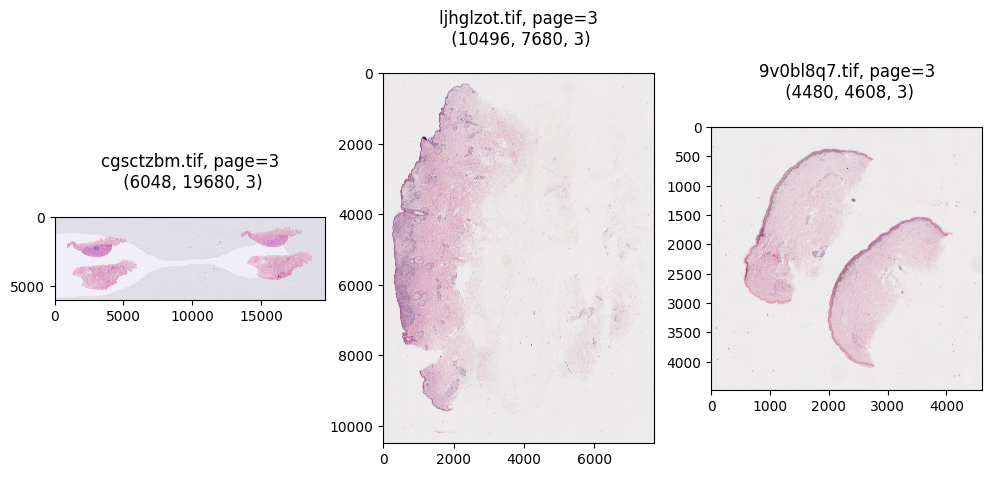

In [12]:
# let's look at a few high-resolution pages from our selected images
visualize_page(3, selected_image_paths)

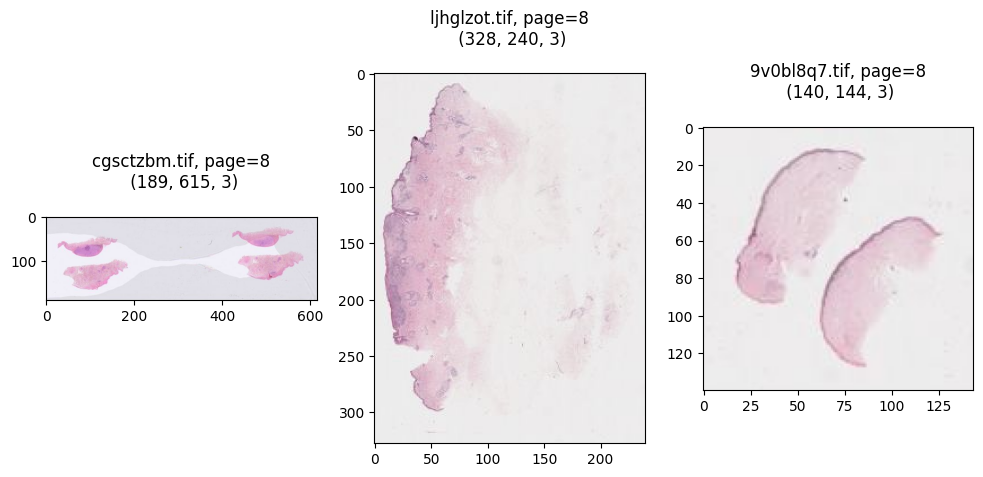

In [13]:
# let's look at low-resolution pages from the same images
visualize_page(8, selected_image_paths)

# Training the model

## Preprocessing
To start, let's do some feature engineering! We'll first take a look at the unique values for each variable in the metadatatrain_metadata.age.unique()

In [17]:
train_metadata.age.unique()

array(['[32:34[', '[46:48[', '[64:66[', '[62:64[', '[90:92[', '[74:76[',
       '[68:70[', '[54:56[', '[80:82[', '[72:74[', '[40:42[', '[58:60[',
       '[86:88[', '[60:62[', '[78:80[', '[66:68[', '[38:40[', '[28:30[',
       '[48:50[', '[70:72[', '[42:44[', '[44:46[', '[30:32[', '[52:54[',
       '[56:58[', '[76:78[', '[50:52[', '[82:84[', '[84:86[', '[26:28[',
       '[18:20[', '[34:36[', '[36:38[', '[92:94[', '[88:90[', '[24:26[',
       '[20:22[', '[94:96[', '[22:24[', '[98:100[', '[16:18['],
      dtype=object)

In [64]:
train_metadata.breslow.unique()

array(['<0.8', '[1 : 2[', '[2 : 4[', '[0.8 : 1[', nan, '>=4'],
      dtype=object)

In [18]:
train_metadata.sex.unique()

array([2, 1])

In [19]:
train_metadata.body_site.unique()

array(['thigh', 'trunc', 'face', 'forearm', 'arm', 'leg', 'hand', nan,
       'foot', 'sole', 'finger', 'neck', 'toe', 'seat', 'scalp', 'nail',
       'trunk', 'lower limb/hip', 'hand/foot/nail', 'head/neck',
       'upper limb/shoulder'], dtype=object)

In [20]:
train_metadata.melanoma_history.unique()

array(['YES', 'NO', nan], dtype=object)

So far, we've learned:

- age is available to us in two-year intervals
- melanoma_history is sometimes nan
- body_site categories are not all at the same level of aggregation - for example, some slides are labeled as being from "hand/foot/nail" while some slides are labeled as from the hand, foot, and nail individually.

Let's do the following:

- convert age to integer values
- convert melanoma_history to dummy variables
- For this first pass, we will not use body_site.

In [94]:
# define an encoder for melanoma_history, body_site 
enc = OneHotEncoder(drop="first", sparse_output=False)
df_enc = train_metadata[['melanoma_history','body_site']].copy()
df_enc['body_site']=train_metadata['body_site'].str.replace(' ','_').str.replace('/','_')
enc.fit(df_enc)
enc.get_feature_names_out()

array(['melanoma_history_YES', 'melanoma_history_nan', 'body_site_face',
       'body_site_finger', 'body_site_foot', 'body_site_forearm',
       'body_site_hand', 'body_site_hand_foot_nail',
       'body_site_head_neck', 'body_site_leg', 'body_site_lower_limb_hip',
       'body_site_nail', 'body_site_neck', 'body_site_scalp',
       'body_site_seat', 'body_site_sole', 'body_site_thigh',
       'body_site_toe', 'body_site_trunc', 'body_site_trunk',
       'body_site_upper_limb_shoulder', 'body_site_nan'], dtype=object)

In [93]:
# define an encoder for breslow
# enc_l = LabelEncoder()
# enc_l.fit(train_metadata['breslow'])

In [95]:
def preprocess_feats(df=train_metadata):
    feats = df.copy()
    # take the first age in the range and convert to integer
    feats["age_int"] = feats.age.str.slice(1, 3).astype(int)
    feats['body_site']=feats['body_site'].str.replace(' ','_').str.replace('/','_')
    X = pd.concat(
        [
            feats[["age_int", "sex","resolution"]],
            pd.DataFrame(
                enc.transform(feats[["melanoma_history","body_site"]]),
                columns=enc.get_feature_names_out(),
                index=feats.index,
            ),
        ],
        axis=1,
    )

    return X

In [96]:
# preprocess features

X = preprocess_feats(train_metadata)
X

,age_int,sex,resolution,melanoma_history_YES,melanoma_history_nan,body_site_face,body_site_finger,body_site_foot,body_site_forearm,body_site_hand,...,body_site_neck,body_site_scalp,body_site_seat,body_site_sole,body_site_thigh,body_site_toe,body_site_trunc,body_site_trunk,body_site_upper_limb_shoulder,body_site_nan
0,32,2,0.264384,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,46,1,0.264384,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,64,2,0.264384,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,62,2,0.226490,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,90,2,0.226490,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1337,68,1,0.250000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1338,66,1,0.250000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1339,80,1,0.250000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1340,42,2,0.250000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [98]:
# take labels from train_labels.csv

y = train_labels.relapse

## Model training and calibration
For a first pass at training, we will have a simple stratified 80-20 split between train and test. The stratified split helps ensure that the proportion of relapse cases are similar between our train and test set and that we are performing our model training on a representative subset of the data.

In [99]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

In [100]:
X_test

,age_int,sex,resolution,melanoma_history_YES,melanoma_history_nan,body_site_face,body_site_finger,body_site_foot,body_site_forearm,body_site_hand,...,body_site_neck,body_site_scalp,body_site_seat,body_site_sole,body_site_thigh,body_site_toe,body_site_trunc,body_site_trunk,body_site_upper_limb_shoulder,body_site_nan
1242,52,2,0.220512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
460,26,2,0.226490,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
614,56,2,0.242797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
317,70,2,0.264384,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
263,80,1,0.250000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,50,2,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
174,46,1,0.250000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1045,66,1,0.263223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
905,42,2,0.250000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
y_train.value_counts(normalize=True)

relapse
0    0.841566
1    0.158434
Name: proportion, dtype: float64

In [102]:
y_test.value_counts(normalize=True)

relapse
0    0.840149
1    0.159851
Name: proportion, dtype: float64

### Random Forest

In [103]:
# fit a calibrated random forest model

rf = RandomForestClassifier(random_state=SEED)
calibrated_rf = CalibratedClassifierCV(rf, method="sigmoid", cv=5)
calibrated_rf.fit(X_train, y_train)

CalibratedClassifierCV(cv=5, estimator=RandomForestClassifier(random_state=42))

### AdaBoost

In [104]:
clf = DecisionTreeClassifier(criterion='entropy') #max_depth=1
boost = AdaBoostClassifier(base_estimator=clf, n_estimators=100)
calibrated_boost = CalibratedClassifierCV(boost, method="sigmoid", cv=5)
calibrated_boost.fit(X_train, y_train)

/opt/mamba/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


CalibratedClassifierCV(cv=5,
                       estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy'),
                                                    n_estimators=100))

### Gradient Boosting

In [106]:
modelGB = GradientBoostingClassifier(learning_rate=0.1,n_estimators=100) #,max_depth=1
calibrated_GB = CalibratedClassifierCV(modelGB, method="sigmoid", cv=5)
modelGB_fit = calibrated_GB.fit(X_train,y_train)

### Stacking

In [37]:
# lr = LogisticRegression()
# stack = StackingClassifier(classifiers=[calibrated_rf, calibrated_GB], meta_classifier=lr)
# stack.fit(X_train, y_train)

## Predicting on validation set

In [107]:
def score(y_true, y_pred):
    return log_loss(y_true, y_pred, eps=1e-16)

In [108]:
preds = calibrated_rf.predict_proba(X_test)[:, 1]
score(y_test, preds)

0.43255206082785064

In [109]:
# make class predictions for the testing set
preds_boost = calibrated_boost.predict_proba(X_test)[:, 1]
score(y_test, preds_boost)

0.4371359845689606

In [110]:
preds_GB = modelGB_fit.predict_proba(X_test)[:, 1]
score(y_test, preds_GB)

0.4149012281446682

In [38]:
# preds_stack = stack.predict_proba(X_test)[:, 1]
# score(y_test, preds_stack)

# CODE SUBMISSION

In [88]:
Path("submission/assets").mkdir(exist_ok=True, parents=True)

# save out model to assets directory in submission folder
dump(calibrated_GB, "submission/assets/gradient_boosting_model.joblib")

# save out encoder to assets directory as well
dump(enc, "submission/assets/hotencoder.joblib")
dump(enc_l, "submission/assets/labelencoder.joblib")

['submission/assets/labelencoder.joblib']

In [92]:
%%writefile submission/main.py

"""Solution for VisioMel Challenge"""

from joblib import load
from pathlib import Path

from loguru import logger
import numpy as np
import pandas as pd


DATA_ROOT = Path("/code_execution/data/")


def preprocess_feats(df, enc,enc_l):
    feats = df.copy()
    # take the first age in the range and convert to integer
    feats["age_int"] = feats.age.str.slice(1, 3).astype(int)
    feats['body_site']=feats['body_site'].str.replace(' ','_').str.replace('/','_')
    feats['breslow'] = enc_l.transform(feats['breslow'])
    X = pd.concat(
        [
            feats[["age_int", "sex","resolution","tif_size","breslow"]],
            pd.DataFrame(
                enc.transform(feats[["melanoma_history","body_site","ulceration"]]),
                columns=enc.get_feature_names_out(),
                index=feats.index,
            ),
        ],
        axis=1,
    )

    return X
    
    
def main():
    # load sumission format
    submission_format = pd.read_csv(DATA_ROOT / "submission_format.csv", index_col=0)
    
    # load test_metadata
    test_metadata = pd.read_csv(DATA_ROOT / "test_metadata.csv", index_col=0)
    
    logger.info("Loading feature encoder and model")
    calibrated_GB = load("assets/gradient_boosting_model.joblib")
    enc = load("assets/hotencoder.joblib")
    enc_l = load("assets/labelencoder.joblib")
    
    logger.info("Preprocessing features")
    processed_features = preprocess_feats(test_metadata, enc, enc_l)
        
    logger.info("Checking test feature filenames are in the same order as the submission format")
    assert (processed_features.index == submission_format.index).all()
    
    logger.info("Checking test feature columns align with loaded model")
    assert (processed_features.columns == calibrated_GB.feature_names_in_).all()
    
    logger.info("Generating predictions")
    submission_format["relapse"] = calibrated_GB.predict_proba(processed_features)[:,1]

    # save as "submission.csv" in the root folder, where it is expected
    logger.info("Writing out submission.csv")
    submission_format.to_csv("submission.csv")


if __name__ == "__main__":
    main()

Overwriting submission/main.py


In [91]:
# zip up submission
! cd submission; zip -r ../submission.zip ./*

  adding: assets/ (stored 0%)
  adding: assets/hotencoder.joblib (deflated 64%)
  adding: assets/gradient_boosting_model.joblib (deflated 69%)
  adding: assets/labelencoder.joblib (deflated 26%)
  adding: main.py (deflated 60%)
